## Classification Model with Linear Model

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import metrics

from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
from sklearn.decomposition import PCA

In [5]:
from sklearn import linear_model
import crowdai

In [80]:
import random

# Loading Genotype and Phenotype

In [184]:
tz_plink = read_plink('ddat/crowdAI/all2964/bin_final_strand')
os_plink = read_plink('ddat/crowdAI/OpenSNP_train')
os_test = read_plink('ddat/crowdAI/OpenSNP_test')

tz_maf = pd.read_csv(PATH/'TZ14_one.frq',delim_whitespace=True)
os_maf =  pd.read_csv(PATH/'OS_freq.frq',delim_whitespace=True)

all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)
os_meta_test = pd.read_csv(TMP_PATH/'os_meta_test.csv',index_col=0)
all_meta.head(),os_meta_test.head()

Mapping files: 100%|██████████| 3/3 [00:13<00:00,  5.97s/it]


(                       ID  height             ChipID  nationality  gender  \
 9992564090_R01C01  TL2257   177.0  9992564090_R01C01            0       1   
 9992564090_R05C01  TL0067   155.0  9992564090_R05C01            0       2   
 9992564090_R07C01  TL0139   143.5  9992564090_R07C01            0       2   
 9992564090_R08C01  TL0279   161.9  9992564090_R08C01            0       2   
 9992564137_R01C01  TL1090   155.2  9992564137_R01C01            0       2   
 
                    biclass  triclass   residual  
 9992564090_R01C01        1         1   8.606139  
 9992564090_R05C01        0         0  -1.518641  
 9992564090_R07C01        0        -1 -13.018641  
 9992564090_R08C01        1         1   5.381359  
 9992564137_R01C01        0         0  -1.318641  ,
     ID  height  ChipID  nationality  gender
 11  11       0      11            1       1
 12  12       0      12            1       2
 14  14       0      14            1       1
 35  35       0      35            1       

# Filter genotype  

In [185]:
tz_maf_filter = tz_maf.apply(select_snp, axis=1)
tz_maf_new=tz_maf.loc[tz_maf_filter==1,]
tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(all_meta.index)]
tz_plink=plink_slice(tz_plink,list(tz_maf_new.index),tz_sample_index)

os_maf_filter = os_maf.apply(select_snp, axis=1)
os_maf_new=os_maf.loc[os_maf_filter==1,]
os_sample_index = [i for i,x in enumerate(os_plink[1].iid) if x in list(all_meta.index)]
os_plink=plink_slice(os_plink,list(os_maf_new.index),os_sample_index)

os_test=plink_slice(os_test,list(os_maf_new.index))

### remove chr 25 because os data don't have chr 25

In [186]:
tz_plink = plink_slice(tz_plink,boo2idx(tz_maf_new.CHR!=25))

# Get GWAS 

In [21]:
snps = {'tz_a':pd.read_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender.csv',index_col=0),
       'tz_f':pd.read_csv(TMP_PATH/'SNPs_GWAS_TZ_Female.csv',index_col=0),
       'tz_m':pd.read_csv(TMP_PATH/'SNPs_GWAS_TZ_Male.csv',index_col=0),
       'os_a':pd.read_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender_OS.csv',index_col=0),
       'os_f':pd.read_csv(TMP_PATH/'SNPs_GWAS_OS_Female.csv',index_col=0),
       'os_m':pd.read_csv(TMP_PATH/'SNPs_GWAS_OS_Male.csv',index_col=0),
       'other':pd.read_csv(TMP_PATH/'snps_sorted_p_val_v2.csv',index_col=0)}

In [188]:
snp_pool = set(tz_plink[0].snp).intersection(os_plink[0].snp)
len(snp_pool)

437252

In [189]:
def topn_snp(s,p,t=500):
    n = 0
    snp = []
    for x in s.index:
        if x in p:
            n +=1
            snp.append(x)
            if n>=t:
                break
    return snp

In [190]:
snp_list=[{k:topn_snp(v,snp_pool,t=n) for k,v in snps.items()} for n in [50,100,200,300,500]]

# Linear model (gender and nationality)

In [126]:
regr = gn_residual(all_meta,test=os_meta_test)

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : eb7e2986-d381-42f2-bcdd-13a5a1c27d2a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : eb7e2986-d381-42f2-bcdd-13a5a1c27d2a


100% |██████████|[00:00<00:00]  104.56% /s] 


CrowdAI.Event.Job.INFO : (eb7e2986-d381-42f2-bcdd-13a5a1c27d2a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.418981198924 ; MSE : 59.0634560883
CrowdAI.Event.Job.COMPLETE : eb7e2986-d381-42f2-bcdd-13a5a1c27d2a	   🍺 


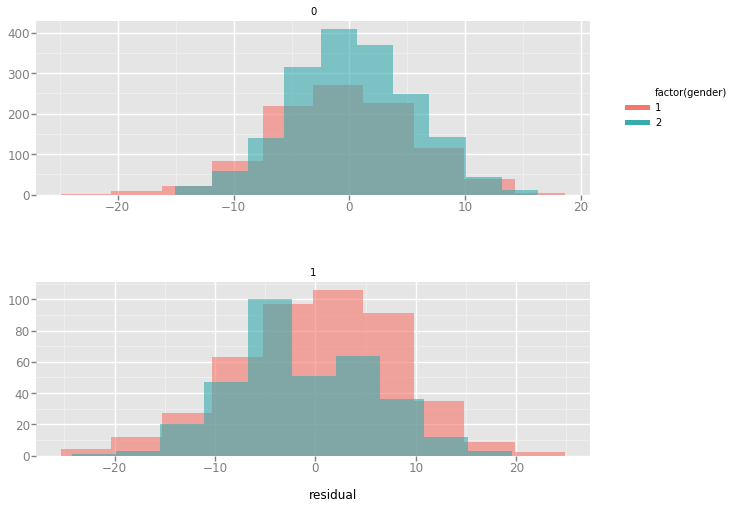

<ggplot: (-9223363305944720219)>

In [86]:
ggplot( aes(x='residual',fill='factor(gender)'),data=all_meta) +\
    geom_histogram(alpha=0.6)+\
    facet_wrap('nationality',scales='free')

(200, 2747) (200, 783) (200, 137)
True
195
(200, 7) (3530, 7) (3530, 200)
3530 2824
(3530, 118) (137, 118)
[(2824, 118), (706, 118), (2747, 118), (783, 118), (137, 118)]
[0.7593332062485578, 0.6796416558965426, 0.7812569910292174, 0.585320621653389]
[0.4486437853582031, 0.5453268641470889, 0.46836543809090453, 0.4753814081303895]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]


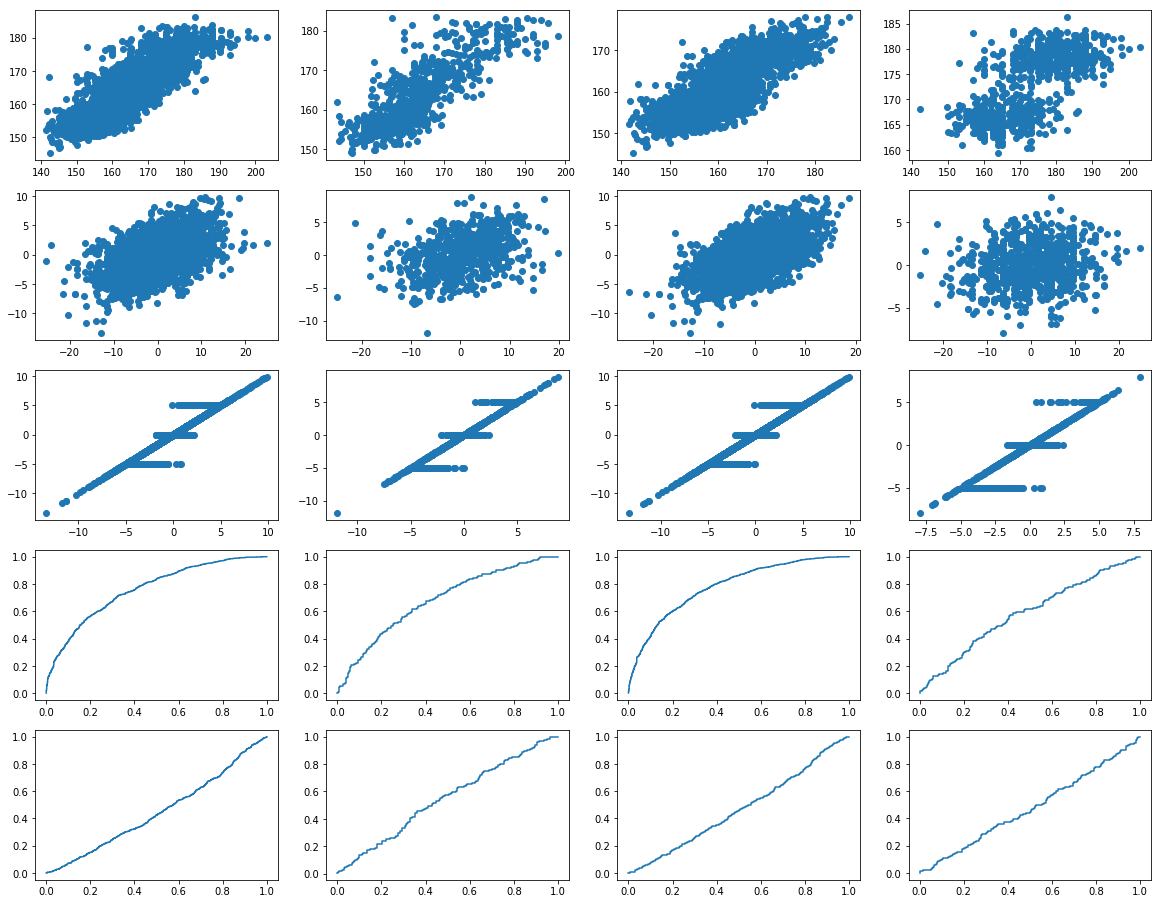

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 4f0e7bd1-f82b-419e-9cb7-73536177ec1e


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 4f0e7bd1-f82b-419e-9cb7-73536177ec1e


100% |██████████|[00:00<00:00]  101.65% /s] 


CrowdAI.Event.Job.INFO : (4f0e7bd1-f82b-419e-9cb7-73536177ec1e) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.369419930731 ; MSE : 64.1016059419
CrowdAI.Event.Job.COMPLETE : 4f0e7bd1-f82b-419e-9cb7-73536177ec1e	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b6cebe0a-2a50-432a-b0b0-d4db026cdbc2


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b6cebe0a-2a50-432a-b0b0-d4db026cdbc2


100% |██████████|[00:00<00:00]  105.26% /s] 


CrowdAI.Event.Job.INFO : (b6cebe0a-2a50-432a-b0b0-d4db026cdbc2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.369419930731 ; MSE : 64.1016059419
CrowdAI.Event.Job.COMPLETE : b6cebe0a-2a50-432a-b0b0-d4db026cdbc2	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : dacf10d3-b234-43af-9a59-f473adec4a15


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : dacf10d3-b234-43af-9a59-f473adec4a15


100% |██████████|[00:00<00:00]  104.56% /s] 


CrowdAI.Event.Job.INFO : (dacf10d3-b234-43af-9a59-f473adec4a15) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.371574708965 ; MSE : 63.8825619981
CrowdAI.Event.Job.COMPLETE : dacf10d3-b234-43af-9a59-f473adec4a15	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 31bd2520-0ec0-4995-b68c-3bcf607702b3


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 31bd2520-0ec0-4995-b68c-3bcf607702b3


100% |██████████|[00:00<00:00]  107.54% /s] 


CrowdAI.Event.Job.INFO : (31bd2520-0ec0-4995-b68c-3bcf607702b3) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.362843886421 ; MSE : 64.7700936115
CrowdAI.Event.Job.COMPLETE : 31bd2520-0ec0-4995-b68c-3bcf607702b3	   🍺 


[[[0.2500334871884716, 28.075980412752095],
  [0.12403468891559144, 36.19741952005042],
  [0.3402704171658115, 20.945138929623717],
  [0.007897728858531572, 60.41590067316881],
  [0.7056962683511365, 28.075980412752095],
  [0.663475784180902, 36.19741952005042],
  [0.6513274836374292, 20.945138929623717],
  [0.4512439860782782, 60.41590067316879]],
 [[0.2500334871884716, 28.075980412752095],
  [0.12403468891559144, 36.19741952005042],
  [0.3402704171658115, 20.945138929623717],
  [0.007897728858531572, 60.41590067316881],
  [0.7056962683511365, 28.075980412752095],
  [0.663475784180902, 36.19741952005042],
  [0.6513274836374292, 20.945138929623717],
  [0.4512439860782782, 60.41590067316879]],
 [[0.24886844808669106, 28.11959518013558],
  [0.12154130272616448, 36.30045344705885],
  [0.3387489859139968, 20.993441430785225],
  [0.006571803397508291, 60.49664535371574],
  [0.7052390807976743, 28.11959518013558],
  [0.6625178868515063, 36.30045344705885],
  [0.6505233946942537, 20.993441430

In [191]:
tmp(all_meta,snp_list[2]['tz_a'],tz_plink,os_plink,os_test)

(400, 2747) (400, 783) (400, 137)
True
389
(400, 7) (3530, 7) (3530, 400)
3530 2824
(3530, 249) (137, 249)
[(2824, 249), (706, 249), (2747, 249), (783, 249), (137, 249)]
[0.8072232645403378, 0.6956804443980638, 0.7890402927140621, 0.7688781507117671]
[0.3903258555984989, 0.5555307286346612, 0.42284385314872197, 0.44008338860987395]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]


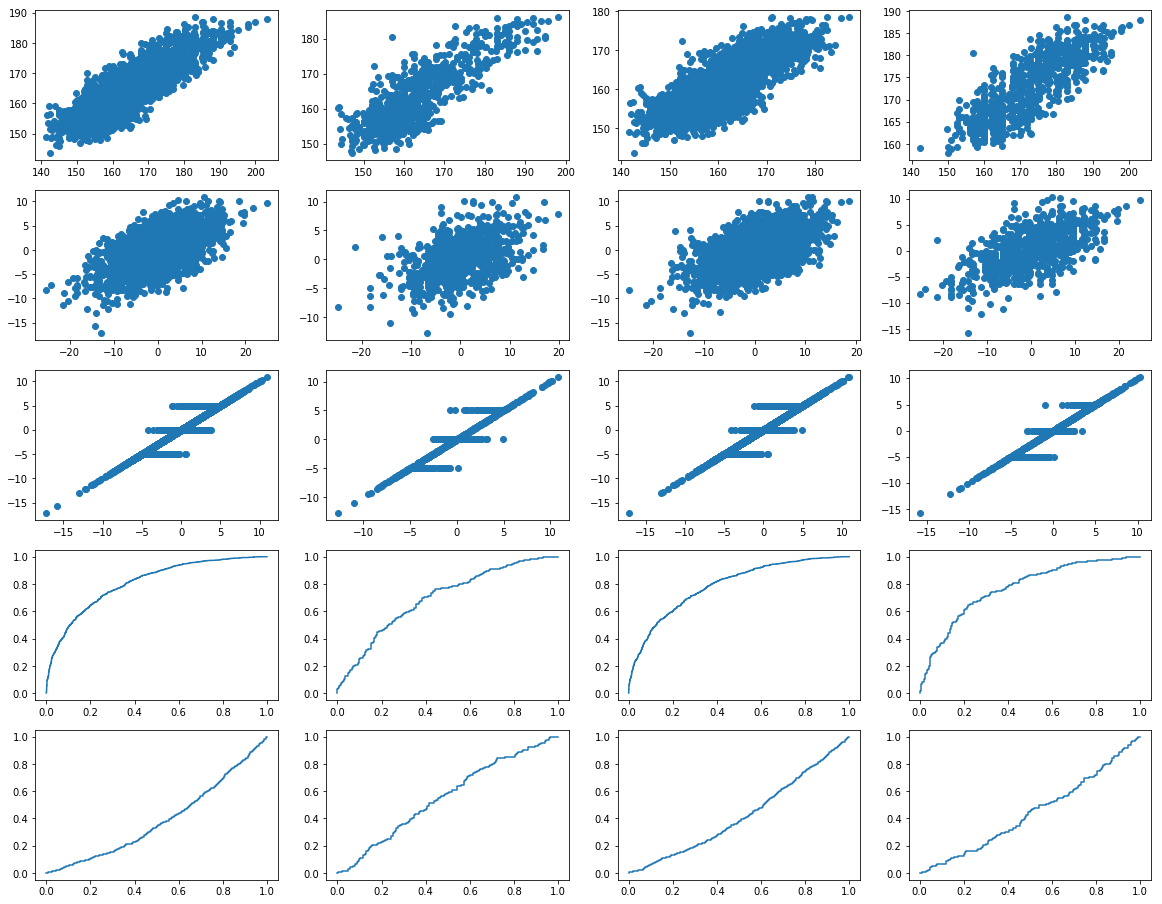

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 762ed805-d249-4acb-a49f-8fbc8b372b62


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 762ed805-d249-4acb-a49f-8fbc8b372b62


100% |██████████|[00:00<00:00]  107.43% /s] 


CrowdAI.Event.Job.INFO : (762ed805-d249-4acb-a49f-8fbc8b372b62) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.383241827182 ; MSE : 62.6965412993
CrowdAI.Event.Job.COMPLETE : 762ed805-d249-4acb-a49f-8fbc8b372b62	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : eb6f846f-d9c9-40c3-a137-4228c27f67af


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : eb6f846f-d9c9-40c3-a137-4228c27f67af


100% |██████████|[00:01<00:00]  71.06% /s] 


CrowdAI.Event.Job.INFO : (eb6f846f-d9c9-40c3-a137-4228c27f67af) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.383241827182 ; MSE : 62.6965412993
CrowdAI.Event.Job.COMPLETE : eb6f846f-d9c9-40c3-a137-4228c27f67af	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 7aba82c4-48d9-4318-bd00-9f8cbe4128c2


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 7aba82c4-48d9-4318-bd00-9f8cbe4128c2


100% |██████████|[00:01<00:00]  88.06% /s] 


CrowdAI.Event.Job.INFO : (7aba82c4-48d9-4318-bd00-9f8cbe4128c2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.377099245233 ; MSE : 63.3209653602
CrowdAI.Event.Job.COMPLETE : 7aba82c4-48d9-4318-bd00-9f8cbe4128c2	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 57f9cce0-9b85-4fce-a455-1e552faa2072


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 57f9cce0-9b85-4fce-a455-1e552faa2072


100% |██████████|[00:00<00:00]  108.94% /s] 


CrowdAI.Event.Job.INFO : (57f9cce0-9b85-4fce-a455-1e552faa2072) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.344233214801 ; MSE : 66.6619611104
CrowdAI.Event.Job.COMPLETE : 57f9cce0-9b85-4fce-a455-1e552faa2072	   🍺 


[[[0.3548152280566299, 24.153338462780408],
  [0.20689041516281026, 32.773581333015144],
  [0.2983759523327324, 22.275207201750327],
  [0.36753836664026307, 38.5149196127617],
  [0.7468149807461164, 24.153338462780408],
  [0.6953069057431807, 32.77358133301516],
  [0.6291859140381708, 22.27520720175033],
  [0.6501700127330714, 38.514919612761716]],
 [[0.3548152280566299, 24.153338462780408],
  [0.20689041516281026, 32.773581333015144],
  [0.2983759523327324, 22.275207201750327],
  [0.36753836664026307, 38.5149196127617],
  [0.7468149807461164, 24.153338462780408],
  [0.6953069057431807, 32.77358133301516],
  [0.6291859140381708, 22.27520720175033],
  [0.6501700127330714, 38.514919612761716]],
 [[0.35470442078018516, 24.15748667856059],
  [0.20861929470591067, 32.70213903121467],
  [0.30207102320910906, 22.157895844378668],
  [0.3615921140070286, 38.877027652342875],
  [0.7467714974780044, 24.157486678560595],
  [0.6959710985201382, 32.70213903121468],
  [0.6311387894194285, 22.15789584

In [192]:
snp = set(snp_list[2]['tz_a']+snp_list[2]['os_a'])
#snp.remove('rs34539857')
tmp(all_meta,snp,tz_plink,os_plink,os_test)

(200, 2747) (200, 783) (200, 137)
True
194
(200, 7) (3530, 7) (3530, 200)
3530 2824
(3530, 134) (137, 134)
[(2824, 134), (706, 134), (2747, 134), (783, 134), (137, 134)]
[0.6561447161160218, 0.578600499305628, 0.5910861528054768, 0.8069870706543032]
[0.40309611829944547, 0.4909346271705822, 0.4279437787552455, 0.40270065384250925]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]


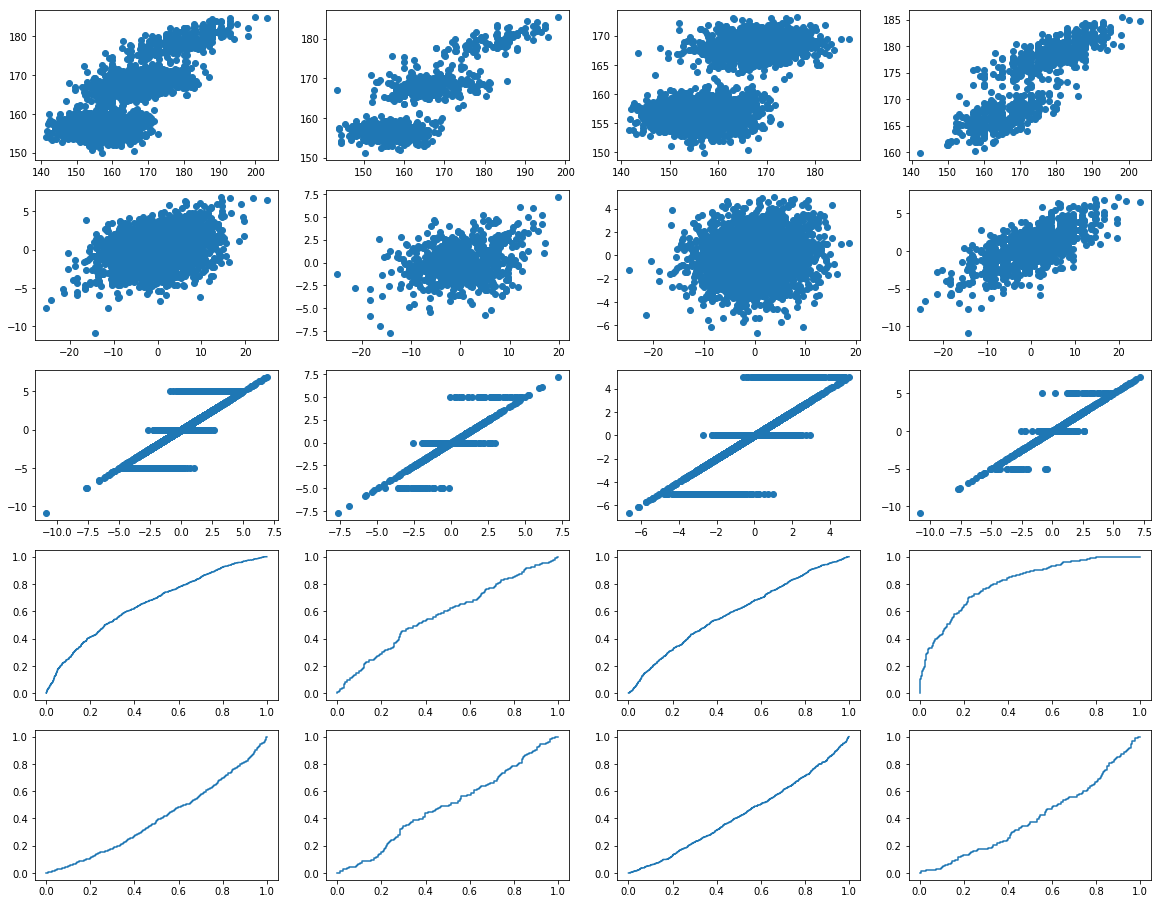

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1d0eb164-8d1b-4d1c-bd4a-61f4891b27e7


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1d0eb164-8d1b-4d1c-bd4a-61f4891b27e7


100% |██████████|[00:00<00:00]  105.09% /s] 


CrowdAI.Event.Job.INFO : (1d0eb164-8d1b-4d1c-bd4a-61f4891b27e7) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.428780077989 ; MSE : 58.0673512078
CrowdAI.Event.Job.COMPLETE : 1d0eb164-8d1b-4d1c-bd4a-61f4891b27e7	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 87f91f81-d34e-4e5c-913c-bf16d7b4ba36


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 87f91f81-d34e-4e5c-913c-bf16d7b4ba36


100% |██████████|[00:01<00:00]  79.21% /s] 


CrowdAI.Event.Job.INFO : (87f91f81-d34e-4e5c-913c-bf16d7b4ba36) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.428780077989 ; MSE : 58.0673512078
CrowdAI.Event.Job.COMPLETE : 87f91f81-d34e-4e5c-913c-bf16d7b4ba36	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : fbedada1-3ed4-411a-91a8-7b5ab7862700


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : fbedada1-3ed4-411a-91a8-7b5ab7862700


100% |██████████|[00:00<00:00]  105.85% /s] 


CrowdAI.Event.Job.INFO : (fbedada1-3ed4-411a-91a8-7b5ab7862700) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.426940870501 ; MSE : 58.254315813
CrowdAI.Event.Job.COMPLETE : fbedada1-3ed4-411a-91a8-7b5ab7862700	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6ef47f71-1283-47cc-aeaf-146fb467b3dc


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6ef47f71-1283-47cc-aeaf-146fb467b3dc


100% |██████████|[00:00<00:00]  108.85% /s] 


CrowdAI.Event.Job.INFO : (6ef47f71-1283-47cc-aeaf-146fb467b3dc) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.425559997283 ; MSE : 58.3946884558
CrowdAI.Event.Job.COMPLETE : 6ef47f71-1283-47cc-aeaf-146fb467b3dc	   🍺 


[[[0.10851595844920026, 33.37387478146155],
  [0.0854116430441586, 37.79343545453951],
  [-0.03339400512646695, 32.80826200551647],
  [0.35393770227235133, 39.34315719616674],
  [0.6501616063492885, 33.37387478146155],
  [0.6486377648438821, 37.793435454539505],
  [0.45384275991758927, 32.80826200551647],
  [0.6426471528603334, 39.34315719616674]],
 [[0.10851595844920026, 33.37387478146155],
  [0.0854116430441586, 37.79343545453951],
  [-0.03339400512646695, 32.80826200551647],
  [0.35393770227235133, 39.34315719616674],
  [0.6501616063492885, 33.37387478146155],
  [0.6486377648438821, 37.793435454539505],
  [0.45384275991758927, 32.80826200551647],
  [0.6426471528603334, 39.34315719616674]],
 [[0.11130773162149954, 33.26936108976553],
  [0.08514755525852613, 37.80434832545539],
  [-0.026621397772612854, 32.59324481418049],
  [0.3475787287894476, 39.73039863437492],
  [0.6512571609487129, 33.269361089765525],
  [0.6485363088457476, 37.804348325455386],
  [0.4574221386658627, 32.5932448

In [193]:
snp = set(snp_list[2]['os_a'])
tmp(all_meta,snp,tz_plink,os_plink,os_test)

(533, 2747) (533, 783) (533, 137)
True
517
(533, 7) (3530, 7) (3530, 533)
3530 2824
(3530, 327) (137, 327)
[(2824, 327), (706, 327), (2747, 327), (783, 327), (137, 327)]
[0.8370589238594978, 0.7129634832588121, 0.8465567822658198, 0.6674415567454617]
[0.3654252786646502, 0.47047369765066394, 0.37830744006991546, 0.4280678480053065]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]


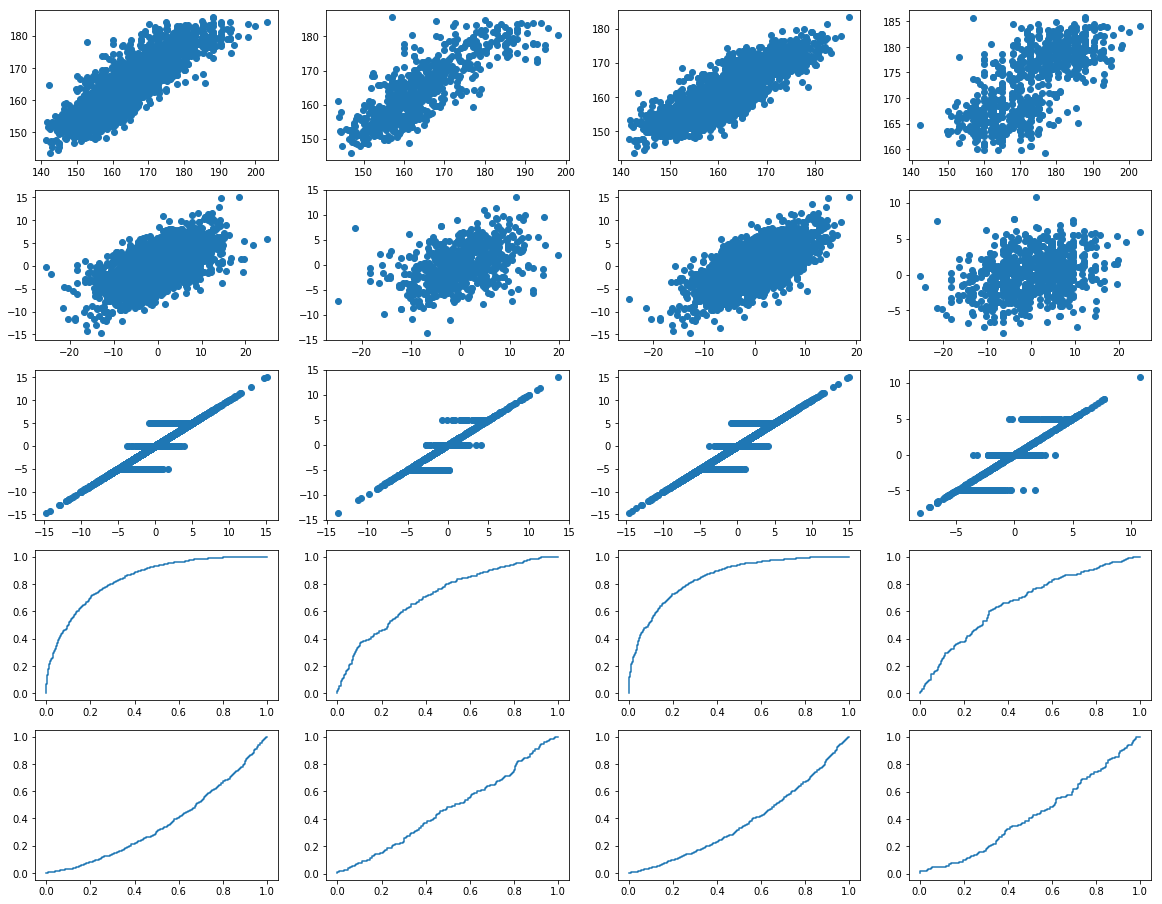

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ec7ad6a4-dea4-4b60-b467-bba7c118834b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ec7ad6a4-dea4-4b60-b467-bba7c118834b


100% |██████████|[00:00<00:00]  108.05% /s] 


CrowdAI.Event.Job.INFO : (ec7ad6a4-dea4-4b60-b467-bba7c118834b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.333891023731 ; MSE : 67.7132963633
CrowdAI.Event.Job.COMPLETE : ec7ad6a4-dea4-4b60-b467-bba7c118834b	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 1195b3ac-3f02-4292-bfb1-dd5b998c73c2


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 1195b3ac-3f02-4292-bfb1-dd5b998c73c2


100% |██████████|[00:01<00:00]  99.45% /s] 


CrowdAI.Event.Job.INFO : (1195b3ac-3f02-4292-bfb1-dd5b998c73c2) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.333891023731 ; MSE : 67.7132963633
CrowdAI.Event.Job.COMPLETE : 1195b3ac-3f02-4292-bfb1-dd5b998c73c2	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 0cd5b020-93b6-47f7-bf95-1815bb20e479


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 0cd5b020-93b6-47f7-bf95-1815bb20e479


100% |██████████|[00:00<00:00]  108.99% /s] 


CrowdAI.Event.Job.INFO : (0cd5b020-93b6-47f7-bf95-1815bb20e479) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.331314169024 ; MSE : 67.9752464835
CrowdAI.Event.Job.COMPLETE : 0cd5b020-93b6-47f7-bf95-1815bb20e479	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c1414dd1-4861-4904-8b9c-03a50640d68a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c1414dd1-4861-4904-8b9c-03a50640d68a


100% |██████████|[00:00<00:00]  105.74% /s] 


CrowdAI.Event.Job.INFO : (c1414dd1-4861-4904-8b9c-03a50640d68a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.279564898192 ; MSE : 73.2358177073
CrowdAI.Event.Job.COMPLETE : c1414dd1-4861-4904-8b9c-03a50640d68a	   🍺 


[[[0.3835518445923519, 23.077545518424696],
  [0.16800890978704952, 34.38027756156236],
  [0.46921294760726806, 16.85146284732452],
  [0.09499839571133173, 55.11174464992836],
  [0.7580918755633531, 23.077545518424696],
  [0.6803695926545542, 34.38027756156236],
  [0.719474672614522, 16.851462847324523],
  [0.49942149372280087, 55.111744649928355]],
 [[0.3835518445923519, 23.077545518424696],
  [0.16800890978704952, 34.38027756156236],
  [0.46921294760726806, 16.85146284732452],
  [0.09499839571133173, 55.11174464992836],
  [0.7580918755633531, 23.077545518424696],
  [0.6803695926545542, 34.38027756156236],
  [0.719474672614522, 16.851462847324523],
  [0.49942149372280087, 55.111744649928355]],
 [[0.3818390068003683, 23.14166784852404],
  [0.1712031385429642, 34.2482827932105],
  [0.470832541398028, 16.80004387530982],
  [0.09019280959768505, 55.404389694460306],
  [0.75741971948001, 23.141667848524033],
  [0.6815967363708964, 34.24828279321051],
  [0.7203306412677444, 16.8000438753098

In [194]:
snp = set(snp_list[2]['tz_a']+snp_list[2]['tz_m']+snp_list[2]['tz_f'])
#snp.remove('rs34539857')
tmp(all_meta,snp,tz_plink,os_plink,os_test)

(387, 2747) (387, 783) (387, 137)
True
377
(387, 7) (3530, 7) (3530, 387)
3530 2824
(3530, 261) (137, 261)
[(2824, 261), (706, 261), (2747, 261), (783, 261), (137, 261)]
[0.7102452067301421, 0.5512751559326661, 0.6304442557197885, 0.826302729528536]
[0.3689008850053212, 0.497754937010555, 0.40784670610243184, 0.358030891689567]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]


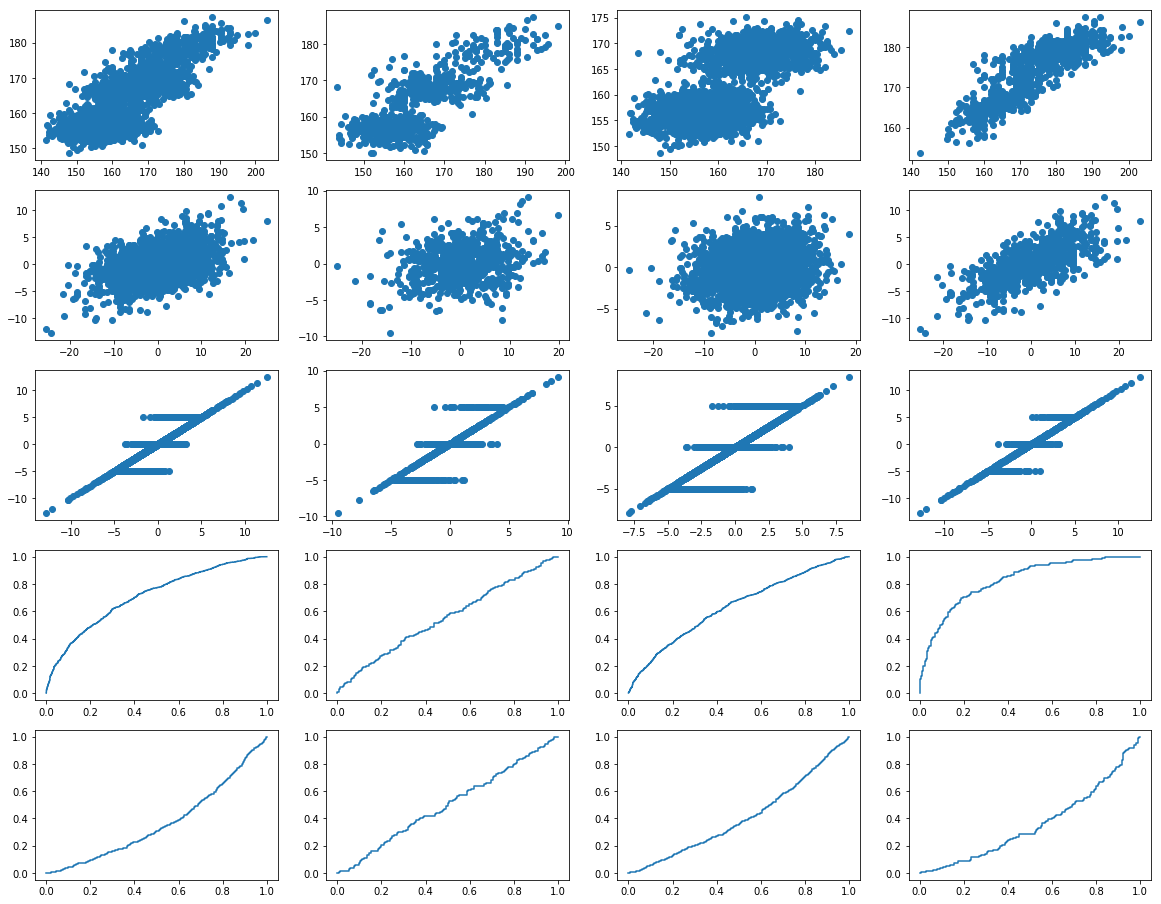

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a3056f23-273d-48c8-a2d4-9a69c200c0cc


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a3056f23-273d-48c8-a2d4-9a69c200c0cc


100% |██████████|[00:01<00:00]  98.11% /s] 


CrowdAI.Event.Job.INFO : (a3056f23-273d-48c8-a2d4-9a69c200c0cc) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.394766737072 ; MSE : 61.5249767855
CrowdAI.Event.Job.COMPLETE : a3056f23-273d-48c8-a2d4-9a69c200c0cc	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : b56c72f5-5371-4173-8e81-2c8d836d7e55


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : b56c72f5-5371-4173-8e81-2c8d836d7e55


100% |██████████|[00:01<00:00]  82.08% /s] 


CrowdAI.Event.Job.INFO : (b56c72f5-5371-4173-8e81-2c8d836d7e55) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.394766737072 ; MSE : 61.5249767855
CrowdAI.Event.Job.COMPLETE : b56c72f5-5371-4173-8e81-2c8d836d7e55	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 121c1960-9fce-481b-8b52-866151fc275a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 121c1960-9fce-481b-8b52-866151fc275a


100% |██████████|[00:00<00:00]  104.67% /s] 


CrowdAI.Event.Job.INFO : (121c1960-9fce-481b-8b52-866151fc275a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.394273938631 ; MSE : 61.5750722024
CrowdAI.Event.Job.COMPLETE : 121c1960-9fce-481b-8b52-866151fc275a	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 74d49a64-6f3b-4b26-ae42-05fa43970942


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 74d49a64-6f3b-4b26-ae42-05fa43970942


100% |██████████|[00:00<00:00]  103.05% /s] 


CrowdAI.Event.Job.INFO : (74d49a64-6f3b-4b26-ae42-05fa43970942) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.38798489224 ; MSE : 62.2143851035
CrowdAI.Event.Job.COMPLETE : 74d49a64-6f3b-4b26-ae42-05fa43970942	   🍺 


[[[0.18980609947400828, 30.33067169415794],
  [0.04108318744869388, 39.62521541609822],
  [-0.0038648108802172843, 31.87076717117766],
  [0.4530410873452211, 33.308073472340126],
  [0.6820616864744335, 30.33067169415794],
  [0.6316078681470962, 39.62521541609822],
  [0.4694491822031679, 31.87076717117767],
  [0.6974636573081725, 33.30807347234012]],
 [[0.18980609947400828, 30.33067169415794],
  [0.04108318744869388, 39.62521541609822],
  [-0.0038648108802172843, 31.87076717117766],
  [0.4530410873452211, 33.308073472340126],
  [0.6820616864744335, 30.33067169415794],
  [0.6316078681470962, 39.62521541609822],
  [0.4694491822031679, 31.87076717117767],
  [0.6974636573081725, 33.30807347234012]],
 [[0.1870115647646805, 30.435288767615933],
  [0.03184103631050916, 40.00712782493829],
  [-0.0027687060594225876, 31.835967962001156],
  [0.43918556544464404, 34.15183107603662],
  [0.680965048185753, 30.435288767615933],
  [0.6280572621757149, 40.00712782493829],
  [0.470028482625656, 31.83596

In [197]:
snp = set(snp_list[2]['os_a']+snp_list[2]['os_f'])
#snp.remove('rs34539857')
tmp(all_meta,snp,tz_plink,os_plink,os_test)

(920, 2747) (920, 783) (920, 137)
True
894
(920, 7) (3530, 7) (3530, 920)
3530 2824
(3530, 568) (137, 568)
[(2824, 568), (706, 568), (2747, 568), (783, 568), (137, 568)]
[0.894220987047386, 0.7104749825403578, 0.8593937697537992, 0.8450894606242655]
[0.28839340727048673, 0.5027877085461355, 0.3401601987678129, 0.3242206007770302]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]


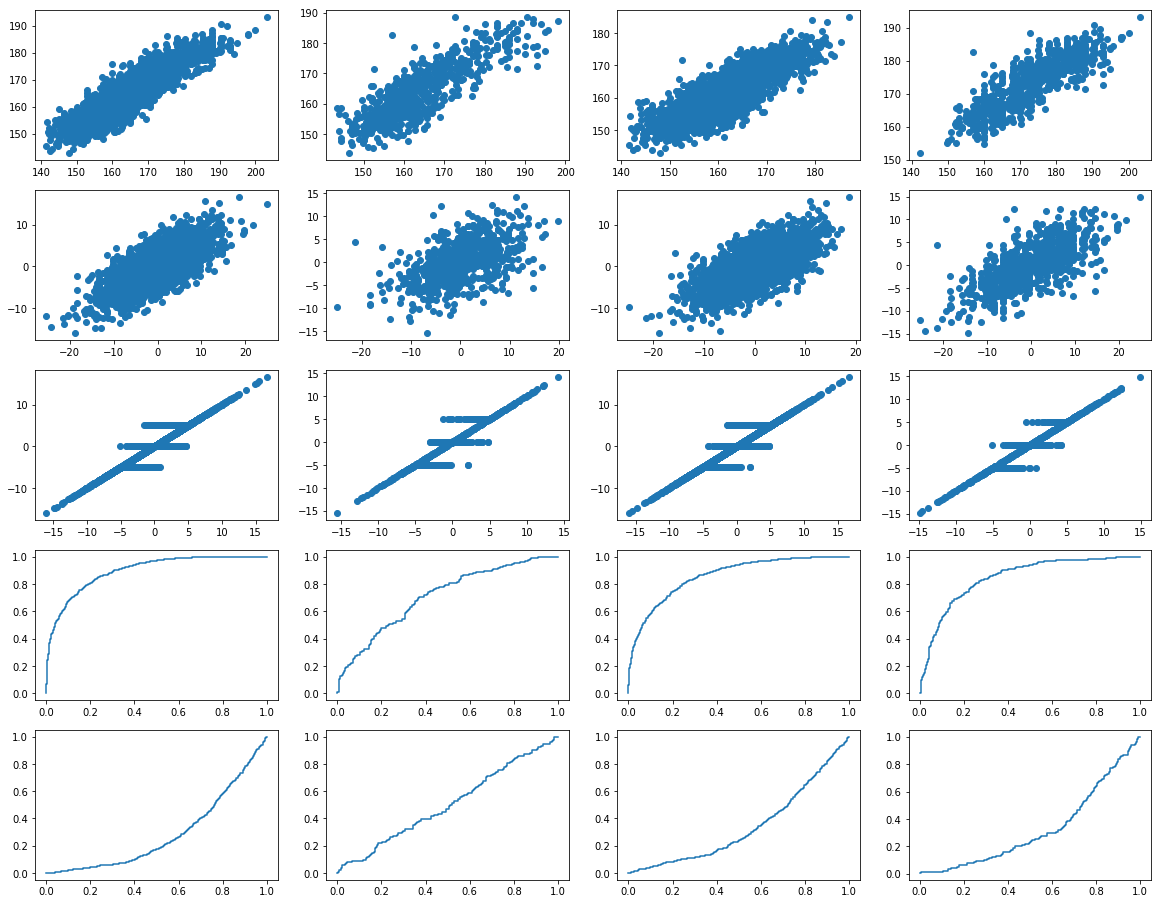

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 12cdf7fc-f506-4838-a53e-d545a2da13e5


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 12cdf7fc-f506-4838-a53e-d545a2da13e5


100% |██████████|[00:00<00:00]  107.94% /s] 


CrowdAI.Event.Job.INFO : (12cdf7fc-f506-4838-a53e-d545a2da13e5) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.34580113426 ; MSE : 66.5025742851
CrowdAI.Event.Job.COMPLETE : 12cdf7fc-f506-4838-a53e-d545a2da13e5	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6f0bb7e5-ffd6-4af4-8de3-f9ddeeea3be6


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6f0bb7e5-ffd6-4af4-8de3-f9ddeeea3be6


100% |██████████|[00:00<00:00]  106.52% /s] 


CrowdAI.Event.Job.INFO : (6f0bb7e5-ffd6-4af4-8de3-f9ddeeea3be6) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.34580113426 ; MSE : 66.5025742851
CrowdAI.Event.Job.COMPLETE : 6f0bb7e5-ffd6-4af4-8de3-f9ddeeea3be6	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 6f8bf6e9-da32-4a8c-bfa5-6b645711ab77


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 6f8bf6e9-da32-4a8c-bfa5-6b645711ab77


100% |██████████|[00:00<00:00]  100.70% /s] 


CrowdAI.Event.Job.INFO : (6f8bf6e9-da32-4a8c-bfa5-6b645711ab77) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.3453868022 ; MSE : 66.5446932035
CrowdAI.Event.Job.COMPLETE : 6f8bf6e9-da32-4a8c-bfa5-6b645711ab77	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 12649e88-aa5e-4edf-a139-1132954e1c6f


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 12649e88-aa5e-4edf-a139-1132954e1c6f


100% |██████████|[00:01<00:00]  86.60% /s] 


CrowdAI.Event.Job.INFO : (12649e88-aa5e-4edf-a139-1132954e1c6f) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.32444586556 ; MSE : 68.6734437524
CrowdAI.Event.Job.COMPLETE : 12649e88-aa5e-4edf-a139-1132954e1c6f	   🍺 


[[[0.5339774965887137, 17.446163867539344],
  [0.24093046403579532, 31.366948086302337],
  [0.45523129472402246, 17.295353298389763],
  [0.498708516432836, 30.527071009174815],
  [0.817122285537629, 17.446163867539344],
  [0.7083842509399259, 31.36694808630233],
  [0.7120852539488225, 17.295353298389763],
  [0.7227234284841211, 30.52707100917481]],
 [[0.5339774965887137, 17.446163867539344],
  [0.24093046403579532, 31.366948086302337],
  [0.45523129472402246, 17.295353298389763],
  [0.498708516432836, 30.527071009174815],
  [0.817122285537629, 17.446163867539344],
  [0.7083842509399259, 31.36694808630233],
  [0.7120852539488225, 17.295353298389763],
  [0.7227234284841211, 30.52707100917481]],
 [[0.5306253610140552, 17.5716554610002],
  [0.22801652035465825, 31.90058958005708],
  [0.45827846460012256, 17.1986115453174],
  [0.47780159329754457, 31.800236718260493],
  [0.8158068321250274, 17.5716554610002],
  [0.703423033052146, 31.900589580057073],
  [0.7136957083169889, 17.1986115453174

In [198]:
snp = set(snp_list[2]['tz_a']+snp_list[2]['tz_m']+snp_list[2]['tz_f']+snp_list[2]['os_a']+snp_list[2]['os_f'])
#snp.remove('rs34539857')
tmp(all_meta,snp,tz_plink,os_plink,os_test)

In [91]:
def tmp(meta,snp,tz_plink,os_plink,os_test):

    tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
    tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
    tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)

    os_snp_index = [i for i,x in enumerate(os_plink[0].snp) if x in snp]
    os_sample_index = [i for i,x in enumerate(os_plink[1].iid) if x in list(meta.index)]
    os_sub=plink_slice(os_plink,os_snp_index,os_sample_index)

    os_sub_test=plink_slice(os_test,os_snp_index)
    #check test sample and training sample having same snps
    print(tz_sub[2].shape,os_sub[2].shape,os_sub_test[2].shape)
    print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
    #but some of them have opposite a0 and a1
    print(sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)]))
    
    os_sub_align = align_a0_a1(tz_sub,os_sub)
    os_sub_test_align = align_a0_a1(tz_sub,os_sub_test)
    
    all_bim = tz_sub[0]
    all_fam = tz_sub[1].append(os_sub[1])
    #row sample and column snps
    all_bed_T= pd.DataFrame(tz_sub[2].compute()).T.append(os_sub_align.T)
    all_bed_T.fillna(-1,inplace=True)
    all_bed_T.index = list(all_fam.iid)
    all_bed_T.columns=list(all_bim.snp)
    print(all_bim.shape,all_fam.shape,all_bed_T.shape)
    
    os_sub_test_align_T = os_sub_test_align.T
    os_sub_test_align_T.columns = list(all_bim.snp)
    os_sub_test_align_T.fillna(-1,inplace=True)
    
    samp_size=len(all_meta)
    train_ratio = 0.8
    train_size = int(samp_size * train_ratio)
    random.seed(1)
    val_idx = random.sample(range(samp_size), samp_size-train_size)
    print(samp_size,train_size)
    
    m=linear_model.LinearRegression()
    X = all_bed_T
    y = all_meta
    Xt = os_sub_test_align_T
    yt = os_meta_test
    mr = regr
    
    tmp = super_model(m,X,y,Xt,yt,val_idx,mr,pca=True)
    
    return tmp

## align a0 and a1 to a ref. (reverse 0 and 2 genotype)

In [88]:
def align_a0_a1(refp,p):
    refbim=refp[0].reset_index(drop=True)
    pbim=p[0].reset_index(drop=True)
    if refbim.snp.equals(pbim.snp) and refbim.pos.equals(pbim.pos):
        diff_idx=[x!=y for x,y in zip(refbim.a0,pbim.a0)]
        if all([x==y for x,y in zip(refbim.a0[diff_idx],pbim.a1[diff_idx])]):
            pbed = pd.DataFrame(p[2].compute())
            tmp = pbed.copy()
            #tmp1 = pbed.copy()
            tmp = tmp.iloc[diff_idx,:]
            #tmp1 = tmp1.iloc[diff_idx,:]
            tmp.replace([0,2],[2,0],inplace=True)
            pbed.loc[diff_idx]=tmp
            return pbed
        else:
            print("can't alignment")
    else:
        print('error happens in align')

(399, 2747) (399, 783) (399, 137)
True
388
(399, 7) (3530, 7) (3530, 399)
3530 2824
(3530, 248) (137, 248)
[(2824, 248), (706, 248), (2747, 248), (783, 248), (137, 248)]
[0.807256373468712, 0.6954958136995978, 0.7890037140588206, 0.7692699490662139]
[0.39149862768162214, 0.5541475144705482, 0.4230273089062714, 0.4428219463659623]
[[0.6075774549753932, 37.43631664439255], [0.6158240422180106, 41.322964766456074], [0.4714917665739973, 31.748066896809004], [0.44687555921997046, 60.89684746276911]]


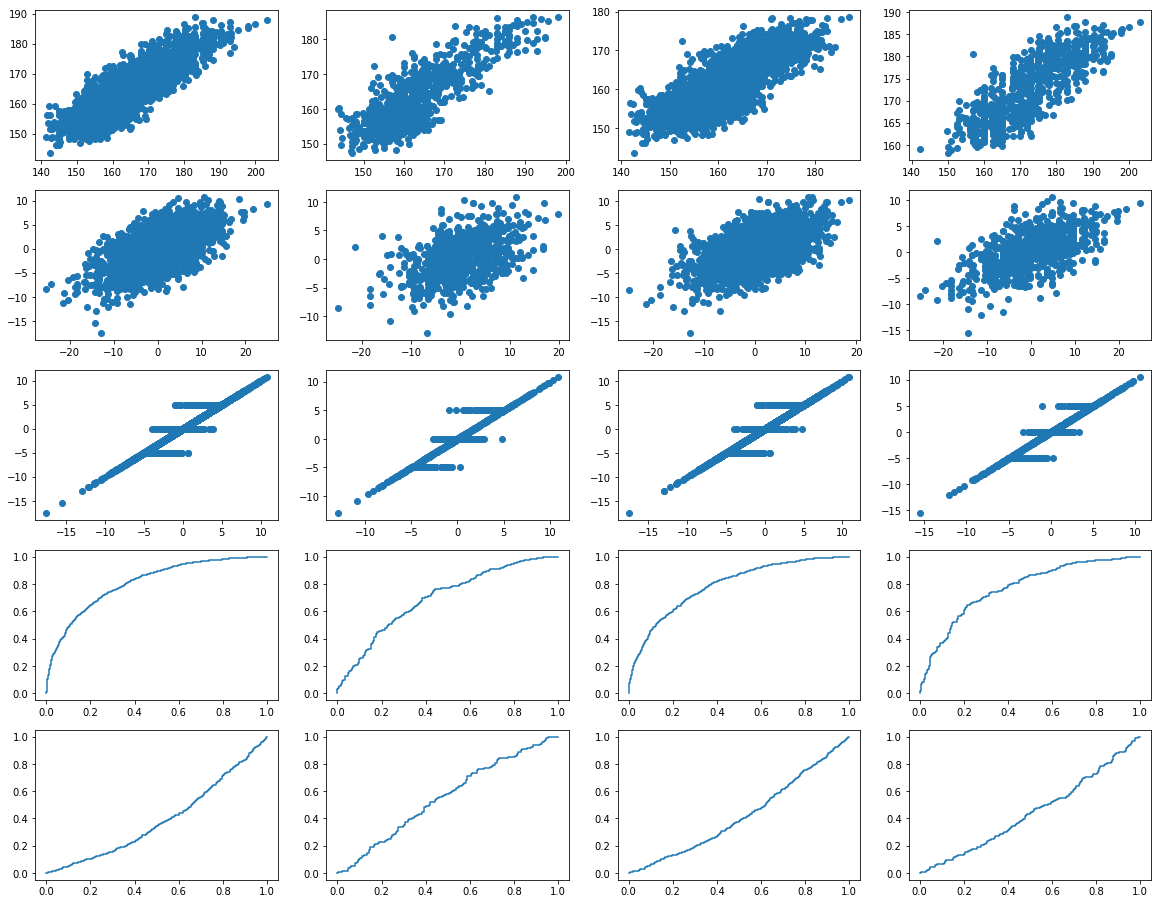

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : 0c118744-c70e-47b7-92c2-4732eda0932b


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : 0c118744-c70e-47b7-92c2-4732eda0932b


100% |██████████|[00:00<00:00]  103.32% /s] 


CrowdAI.Event.Job.INFO : (0c118744-c70e-47b7-92c2-4732eda0932b) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.381216631534 ; MSE : 62.9024125276
CrowdAI.Event.Job.COMPLETE : 0c118744-c70e-47b7-92c2-4732eda0932b	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c42c880c-a4d1-4ce2-8103-045aee7e8c93


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c42c880c-a4d1-4ce2-8103-045aee7e8c93


100% |██████████|[00:00<00:00]  106.93% /s] 


CrowdAI.Event.Job.INFO : (c42c880c-a4d1-4ce2-8103-045aee7e8c93) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.381216631534 ; MSE : 62.9024125276
CrowdAI.Event.Job.COMPLETE : c42c880c-a4d1-4ce2-8103-045aee7e8c93	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc957d06-d054-4b02-9b07-48bd076bcf64


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc957d06-d054-4b02-9b07-48bd076bcf64


100% |██████████|[00:00<00:00]  108.48% /s] 


CrowdAI.Event.Job.INFO : (bc957d06-d054-4b02-9b07-48bd076bcf64) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.375802053332 ; MSE : 63.4528313802
CrowdAI.Event.Job.COMPLETE : bc957d06-d054-4b02-9b07-48bd076bcf64	   🍺 
CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : a4e296be-315f-49b6-bf94-ebeaf73bf05c


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : a4e296be-315f-49b6-bf94-ebeaf73bf05c


100% |██████████|[00:00<00:00]  103.00% /s] 


CrowdAI.Event.Job.INFO : (a4e296be-315f-49b6-bf94-ebeaf73bf05c) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.343507652524 ; MSE : 66.7357181311
CrowdAI.Event.Job.COMPLETE : a4e296be-315f-49b6-bf94-ebeaf73bf05c	   🍺 


[[[0.3540917420959523, 24.18042310897979],
  [0.2070321530191136, 32.76772431495568],
  [0.2985869568701526, 22.26850821558078],
  [0.3656350559488525, 38.63082523361079],
  [0.7465310685788586, 24.180423108979795],
  [0.6953613579233535, 32.76772431495569],
  [0.6292974316734876, 22.26850821558078],
  [0.6491172450712543, 38.63082523361079]],
 [[0.3540917420959523, 24.18042310897979],
  [0.2070321530191136, 32.76772431495568],
  [0.2985869568701526, 22.26850821558078],
  [0.3656350559488525, 38.63082523361079],
  [0.7465310685788586, 24.180423108979795],
  [0.6953613579233535, 32.76772431495569],
  [0.6292974316734876, 22.26850821558078],
  [0.6491172450712543, 38.63082523361079]],
 [[0.3535924882551754, 24.199113331563325],
  [0.2090060482521331, 32.68615725638143],
  [0.30192418886890826, 22.162557550834112],
  [0.35963195349545196, 38.9963952480189],
  [0.7463351501400075, 24.199113331563325],
  [0.6961196796707966, 32.68615725638143],
  [0.6310611862616827, 22.162557550834112],
  

In [160]:
snp = set(snp_list[2]['tz_a']+snp_list[2]['os_a'])
snp.remove('rs34539857')
tmp(all_meta,snp,tz_plink,os_plink,os_test)

align genotype of opensnp traing and test data to taizhao

In [35]:
os_sub_align = align_a0_a1(tz_sub,os_sub)
os_sub_test_align = align_a0_a1(tz_sub,os_sub_test)

## Merge training data from taizhou and opensnp 

In [36]:
all_bim = tz_sub[0]
all_fam = tz_sub[1].append(os_sub[1])
#row sample and column snps
all_bed_T= pd.DataFrame(tz_sub[2].compute()).T.append(os_sub_align.T)
all_bed_T.fillna(-1,inplace=True)
all_bed_T.index = list(all_fam.iid)
all_bed_T.columns=list(all_bim.snp)
all_bed_T=all_bed_T.loc[:,list(snps_tz.index[snp_pv_idx])]
all_bim.shape,all_fam.shape,all_bed_T.shape

((500, 7), (3530, 7), (3530, 500))

In [37]:
os_sub_test_align_T = os_sub_test_align.T
os_sub_test_align_T.columns = list(all_bim.snp)
os_sub_test_align_T=os_sub_test_align_T.loc[:,list(snps_tz.index[snp_pv_idx])]
#Replace nan values in the training and testing set with an arbitrary number (-1)
os_sub_test_align_T.fillna(-1,inplace=True)

In [48]:
samp_size=len(all_meta)
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

import random
random.seed(1)
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)

3530 2824


In [49]:
m=linear_model.LinearRegression()
X = all_bed_T
y = all_meta
Xt = os_sub_test_align_T
yt = os_meta_test
mr = regr

In [161]:
tmp = super_model(m,X,y,Xt,yt,val_idx,mr,pca=True)

NameError: name 'm' is not defined

In [81]:
def submit(x):
    challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
    challenge.submit(x.tolist())
    challenge.disconnect()

In [110]:
def model_pred(ml,dt,p=False):
    pr= []
    if p:
        for d in dt:
            pr.append(ml.predict_proba(d)[:,1])
    else:
        for d in dt:
            pr.append(ml.predict(d))
    return pr

In [111]:
def super_model(m,X,y,Xt,yt,val_idx,mr,pca=True):
    #pca
    if pca:        
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        Xt = pd.DataFrame(pca.transform(Xt))
        print(X.shape,Xt.shape)
    #data    
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
    
    tes,gn_tes = Xt.values, yt[['gender','nationality']].values
    
    tz_idx = boo2idx(y.nationality==0)
    ((tz,os), (y_tz,y_os)) = split_by_idx(tz_idx, X.values, np.array(y.residual))
    ((gn_tz,gn_os),(gn_y_tz,gn_y_os)) = split_by_idx(tz_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_tz,yb_os),(yt_tz,yt_os)) = split_by_idx(tz_idx,y.biclass,y.triclass)
    #print([x.shape for x in [trn,val,tz,os,tes]])
    #model
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)
    
    #
    yr = [y_trn,y_val,y_tz,y_os]
    yh = [gn_y_trn,gn_y_val,gn_y_tz,gn_y_os]
    yb = [yb_trn,yb_val,yb_tz,yb_os]
    yt = [yt_trn,yt_val,yt_tz,yt_os]
    #pred
    pbase = model_pred(mr,[gn_trn,gn_val,gn_tz,gn_os,gn_tes])
    pr = model_pred(ml,[trn,val,tz,os,tes])
    pbi = model_pred(mb,[trn,val,tz,os,tes])
    pbi_prob = model_pred(mb,[trn,val,tz,os],p=True)
    ptri =  model_pred(mt,[trn,val,tz,os,tes])
    ptri_prob = model_pred(mt,[trn,val,tz,os],p=True)
    ph = [x+y for x,y in zip(pr,pbase)]
    pr_c = [np.clip(x,-20,20) for x in pr]
    ph_c = [x+y for x,y in zip(pr_c,pbase)]
    pr_b = [biclip(x,b) for x,b in zip(pr_c,pbi)]
    ph_b = [x+y for x,y in zip(pr_b,pbase)]
    pr_t = [triclip(x,b,t) for x,b,t in zip(pr_c,pbi,ptri)]
    ph_t = [x+y for x,y in zip(pr_t,pbase)]
    
    fpr_b,tpr_b,auc_b=[],[],[]
    for y,scores in zip(yb,pbi_prob):
        #print(y,scores)
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        auc_b.append(metrics.auc(fpr, tpr))
        fpr_b.append(fpr)
        tpr_b.append(tpr)
    print(auc_b)
    fpr_t,tpr_t,auc_t=[],[],[]
    for y,scores in zip(yt,ptri_prob):
        fpr, tpr, _ = metrics.roc_curve(y, scores,pos_label=1)
        auc_t.append(metrics.auc(fpr, tpr))
        fpr_t.append(fpr)
        tpr_t.append(tpr)  
    print(auc_t)
    
    print([[metrics.r2_score(x,y),metrics.mean_squared_error(x,y)] for x,y in zip(yh,pbase[:-1])])
    tmp = [[[metrics.r2_score(x,y),metrics.mean_squared_error(x,y)] for x,y in zip(yr+yh,t)] 
           for t in [pr[:-1]+ph[:-1],pr_c[:-1]+ph_c[:-1],pr_b[:-1]+ph_b[:-1],pr_t[:-1]+ph_t[:-1]]]
    
    f, axs = plt.subplots(5, 4,figsize=(20, 16))
    axs = axs.ravel()
    for i,x,y in zip(list(range(12)),yh+yr+pr[:-1],ph[:-1]+pr[:-1]+pr_t[:-1]):
        #print(i,x,y)
        axs[i].scatter(x,y,marker='o')
    for i,x,y in zip(list(range(12,21)),fpr_b+fpr_t,tpr_b+tpr_t):
        axs[i].plot(x,y)
    plt.show()

    [submit(pbase[4] + x[4])for x in [pr,pr_c,pr_b,pr_t]]
    
    return tmp

In [93]:
def rsqure(yh,y):
    yhat = yh                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    r2 = ssreg / sstot
    return r2


def clamp(n, smallest, largest): return max(smallest, min(n, largest))
def triclip(pr,pb,pt):
    new_pr=[]
    for i,r in enumerate(pr):
        if pb[i]:
            if pt[i]==1:
                new_pr.append(max(5,r))
            elif pt[i]==0:
                new_pr.append(max(0,r))
            else:
                new_pr.append(0)
        else:
            if pt[i]==1:
                new_pr.append(0)
            elif pt[i]==0:
                new_pr.append(min(0,r))
            else:
                new_pr.append(min(-5,r))
    return np.array(new_pr)
def biclip(pr,pb):
    new_pr=[]
    for i,r in enumerate(pr):
        if pb[i]:
            new_pr.append(max(0,r))
        else:
            new_pr.append(min(0,r))
    return np.array(new_pr)

def model_pred(ml,dt):
    pr= []
    for d in dt:
        pr.append(ml.predict(d))
    return pr

def boo2idx(t):
    return [i for i, x in enumerate(t) if x]

In [109]:
list(range(16))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [84]:
def test():
    
    
    pb_val = mb.predict(val)
    pt_val = mt.predict(val)
    tmp=pd.DataFrame({'yb':yb_val,'yt':yt_val,'pb':pb_val,'pt':pt_val,'v':1})
    print(tmp.pivot_table(['v'],index=['yb'],columns=['pb'],aggfunc=np.sum))
    print(tmp.pivot_table(['v'],index=['yt'],columns=['pt'],aggfunc=np.sum))
    
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(biclip(pr_val,pb_val,pt_val),pr_val,c=pt_val, marker='o')
    ax3.scatter(y_val,pr_val,c=pt_val, marker='o')
    ax4.scatter(y_val,biclip(pr_val,pb_val,pt_val),c=pt_val, marker='o')

    plt.title(n);
    plt.show()
    
    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,mb,mt,score)

In [ ]:
def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))

    ml = m
    ml.fit(trn, y_trn)


    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()

    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,score)


In [176]:


def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
         
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)

    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()
    pb_val = mb.predict(val)
    pt_val = mt.predict(val)
    tmp=pd.DataFrame({'yb':yb_val,'yt':yt_val,'pb':pb_val,'pt':pt_val,'v':1})
    print(tmp.pivot_table(['v'],index=['yb'],columns=['pb'],aggfunc=np.sum))
    print(tmp.pivot_table(['v'],index=['yt'],columns=['pt'],aggfunc=np.sum))
    
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(biclip(pr_val,pb_val,pt_val),pr_val,c=pt_val, marker='o')
    ax3.scatter(y_val,pr_val,c=pt_val, marker='o')
    ax4.scatter(y_val,biclip(pr_val,pb_val,pt_val),c=pt_val, marker='o')

    plt.title(n);
    plt.show()
    
    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,mb,mt,score)

def topsnp_model(m,X,y,val_idx,mr,Xt,yt,topn=[500, 200, 100, 50, 20, 10]):
    score={}
    for n in topn: 
        var_idx = list(range(n))
        ml,mb,mt,score[n] = train_model(m,X.iloc[:,var_idx],y,val_idx,mr)
        ph_test = mr.predict(yt[['gender','nationality']].values)+biclip(np.clip(ml.predict(Xt.iloc[:,var_idx]),-20,20),mb.predict(Xt.iloc[:,var_idx]),mt.predict(Xt.iloc[:,var_idx]))
        challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
        challenge.submit(ph_test.tolist())
        challenge.disconnect()
    return pd.DataFrame(score)

In [43]:
#X=pd.DataFrame(tz_sub[2].compute().T)
#X= X[tz_f_idx]
#X.fillna(-1,inplace=True)
#X=pd.DataFrame(all_bed_pca)
#Xt=pd.DataFrame(os_test_pca)
tz_f_lr = topsnp_model(m=linear_model.LinearRegression(),X=X,y=all_meta,Xt=Xt,yt=os_meta_test,val_idx=val_idx,mr=regr,
                      topn=[300, 200, 100, 50, 20, 10])

tz_f_lr

3530 2824


NameError: name 'all_bed_pca' is not defined

In [45]:
len(val_idx)

706

In [114]:
from sklearn.ensemble import RandomForestRegressor

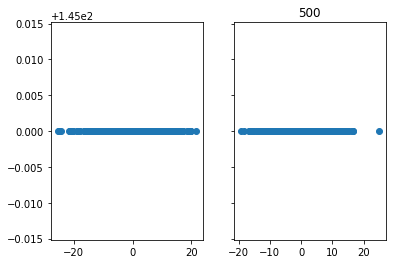

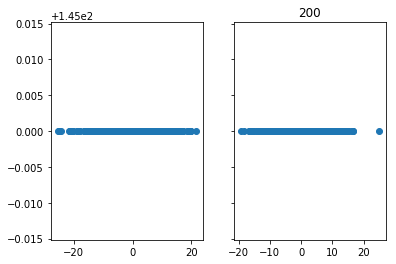

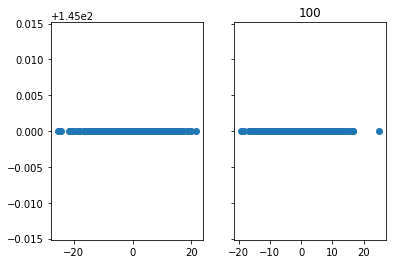

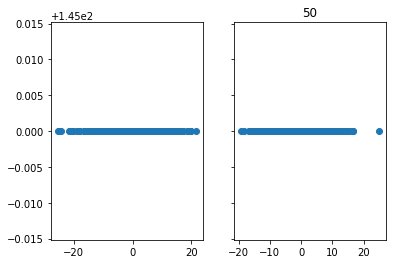

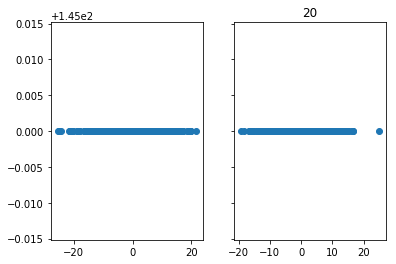

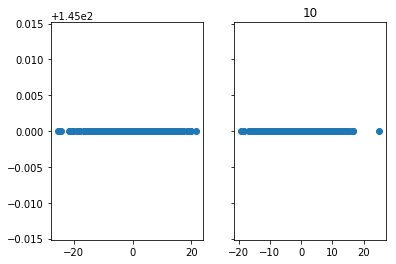

In [115]:
m=RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,n_jobs=-1, oob_score=True)
rf = topsnp_model(m=m,X=X,y=all_meta.residual,val_idx=val_idx)

rf

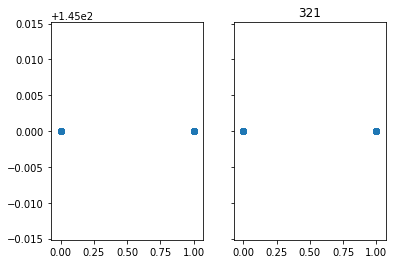

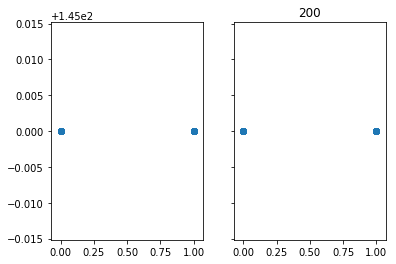

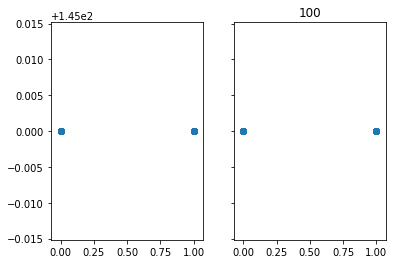

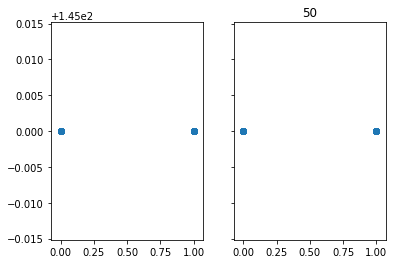

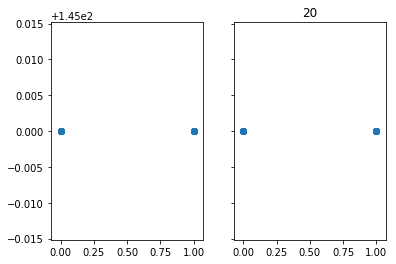

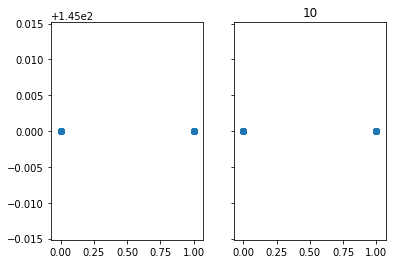

{321: (0.7457507082152974, 0.6543909348441926),
 200: (0.6972379603399433, 0.6175637393767706),
 100: (0.6487252124645893, 0.5949008498583569),
 50: (0.6058781869688386, 0.5708215297450425),
 20: (0.568342776203966, 0.56657223796034),
 10: (0.5559490084985835, 0.5694050991501416)}

In [85]:
tz_f_lg = topsnp_model(m=linear_model.LogisticRegression(),X=X,y=all_meta.biclass,val_idx=val_idx,
                      topn=[321, 200, 100, 50, 20, 10])
tz_f_lg

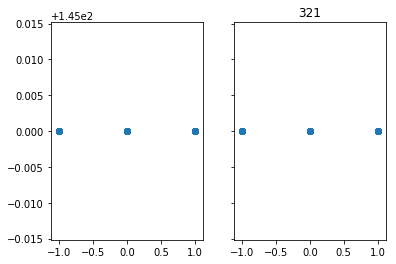

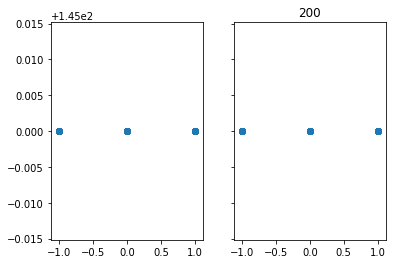

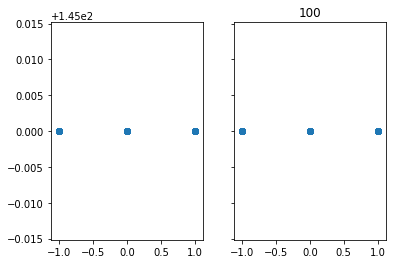

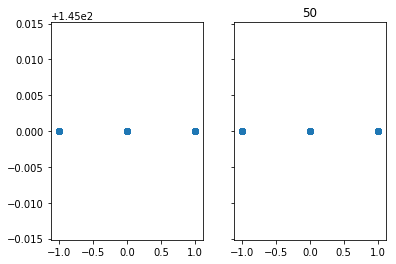

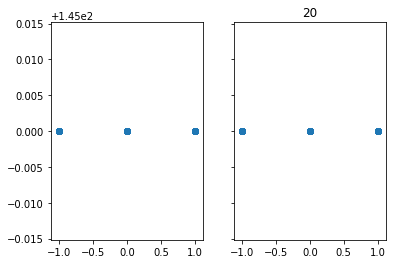

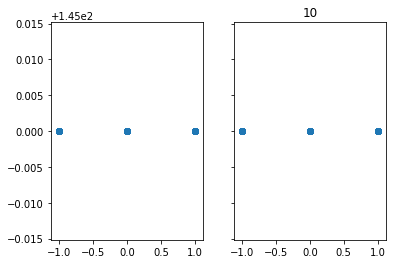

{321: (0.6473087818696884, 0.5),
 200: (0.5991501416430595, 0.48441926345609065),
 100: (0.5428470254957507, 0.4801699716713881),
 50: (0.5339943342776204, 0.4915014164305949),
 20: (0.5226628895184136, 0.5),
 10: (0.5205382436260623, 0.5014164305949008)}

In [86]:
tz_f_lg_triple = topsnp_model(m=linear_model.LogisticRegression(),X=X,y=all_meta.triclass,val_idx=val_idx,
                             topn=[321, 200, 100, 50, 20, 10])
tz_f_lg_triple

## 1.SNPs from the paper

get common genotype with top 10000 list  >>>7726

In [26]:
common_snp = set(snps.snp[0:10000]).intersection(*(tz_bim.snp,os_bim.snp))
len(common_snp)

7726

common snp index in tz and os train data

In [27]:
tz_snp1996_index = [i for i,x in enumerate(tz_bim.snp) if x in common_snp]
os_snp1996_index = [i for i,x in enumerate(os_bim.snp) if x in common_snp]
len(tz_snp1996_index),len(os_snp1996_index)

(7726, 7727)

samples match with meta data

In [41]:
tz_sample_index = [i for i,x in enumerate(tz_fam.iid) if x in list(all_meta.ChipID)]
os_sample_index = [i for i,x in enumerate(os_fam.iid) if int(x) in list(all_meta.ChipID)]
len(tz_sample_index),len(os_sample_index)

(2747, 783)

In [43]:
tz_sub=plink_slice((tz_bim,tz_fam,tz_bed),tz_snp1996_index,tz_sample_index)
os_sub=plink_slice((os_bim,os_fam,os_bed),os_snp1996_index,os_sample_index)

In [166]:
snp=set(snp_list[2]['os_a']+snp_list[2]['os_m']+snp_list[2]['os_f'])
#snp.remove('rs34539857')
meta=all_meta
tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)

os_snp_index = [i for i,x in enumerate(os_plink[0].snp) if x in snp]
os_sample_index = [i for i,x in enumerate(os_plink[1].iid) if x in list(meta.index)]
os_sub=plink_slice(os_plink,os_snp_index,os_sample_index)

os_sub_test=plink_slice(os_test,os_snp_index)
#check test sample and training sample having same snps
print(tz_sub[2].shape,os_sub[2].shape,os_sub_test[2].shape)
print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
#but some of them have opposite a0 and a1
print(sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)]))

(532, 2747) (532, 783) (532, 137)
True
516


In [167]:
diff_idx=np.array(os_sub[0].snp)!= np.array(tz_sub[0].snp)

In [168]:
sum(diff_idx)

103

In [146]:
snp

{'rs10025229',
 'rs10034660',
 'rs10062885',
 'rs10129289',
 'rs1013500',
 'rs10167782',
 'rs10196832',
 'rs1023082',
 'rs10243532',
 'rs10405617',
 'rs1044269',
 'rs10495447',
 'rs10516089',
 'rs10742805',
 'rs10742816',
 'rs10746902',
 'rs10761275',
 'rs10761280',
 'rs10764690',
 'rs10781064',
 'rs10796110',
 'rs10807371',
 'rs10839972',
 'rs10883710',
 'rs10919369',
 'rs10948',
 'rs10956922',
 'rs10969086',
 'rs10974859',
 'rs11004618',
 'rs11012350',
 'rs11022250',
 'rs11045336',
 'rs11072122',
 'rs1109353',
 'rs11111224',
 'rs11181149',
 'rs11181192',
 'rs11222792',
 'rs11258513',
 'rs11621843',
 'rs11622224',
 'rs11623618',
 'rs11635083',
 'rs11686211',
 'rs11723619',
 'rs11830046',
 'rs11878521',
 'rs1188350',
 'rs1188553',
 'rs11980518',
 'rs1199509',
 'rs12011068',
 'rs12011214',
 'rs12014824',
 'rs1202309',
 'rs12230192',
 'rs12300536',
 'rs12325555',
 'rs12358488',
 'rs12368662',
 'rs12387878',
 'rs12411435',
 'rs12529614',
 'rs12557044',
 'rs12642398',
 'rs12645863',
 'rs12

In [145]:
np.array(os_sub[0].snp)==np.array(snp)

array([False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, ..., False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False])

In [174]:
os_sub[0][diff_idx]

,chrom,snp,cm,pos,a0,a1,i
7031344,23,rs1349787,0.0,1867483,A,G,7031344
7031765,23,rs7051519,0.0,1947830,G,T,7031765
7032896,23,rs34539857,0.0,2255569,A,C,7032896
7034009,23,rs17842893,0.0,2477704,A,G,7034009
7034011,23,rs17842894,0.0,2478595,C,A,7034011
7034726,23,rs311121,0.0,2679949,T,G,7034726
7039141,23,rs6530093,0.0,4281033,T,C,7039141
7041681,23,rs5915540,0.0,5371016,A,G,7041681
7042034,23,rs1919026,0.0,5461853,C,T,7042034
7047993,23,rs7064826,0.0,8539504,G,A,7047993


In [170]:
os_sub[0][100:105]

,chrom,snp,cm,pos,a0,a1,i
1844280,4,rs7696872,0.0,82687275,G,A,1844280
1850334,4,rs1847819,0.0,84894991,C,T,1850334
1860940,4,rs12642398,0.0,89323214,C,T,1860940
1861014,4,rs2869665,0.0,89453522,G,A,1861014
1876439,4,rs3796433,0.0,96031455,A,C,1876439


In [153]:
tz_sub[0][tz_sub[0].snp=='rs34539857']

,chrom,snp,cm,pos,a0,a1,i
795102,25,rs34539857,0.0,2255569,A,C,795102


In [154]:
os_sub[0][os_sub[0].snp=='rs34539857']

,chrom,snp,cm,pos,a0,a1,i
7032896,23,rs34539857,0.0,2255569,A,C,7032896


In [175]:
tz_sub[0][tz_sub[0].snp=='rs1349787']

,chrom,snp,cm,pos,a0,a1,i
794956,25,rs1349787,0.0,1867483,A,G,794956


In [176]:
os_sub[0][os_sub[0].snp=='rs1349787']

,chrom,snp,cm,pos,a0,a1,i
7031344,23,rs1349787,0.0,1867483,A,G,7031344


In [180]:
os_maf.CHR.value_counts()

2     580068
1     540295
4     514787
3     496293
6     481937
5     440534
7     415578
8     381386
10    361510
11    351886
12    338781
9     302500
13    258939
14    230057
23    229585
16    213911
15    200927
18    198703
17    192787
19    168232
20    153754
21    100448
22     99051
24       687
Name: CHR, dtype: int64

In [177]:
os_plink[0].chrom.

0

In [152]:
sum(tz_sub[0].snp=='rs34539857')

1

In [148]:
os_sub[0][335:345]

,chrom,snp,cm,pos,a0,a1,i
6869330,21,rs2831806,0.0,29804023,G,A,6869330
6878314,21,rs2833556,0.0,33285300,A,G,6878314
6904741,21,rs914187,0.0,42619749,T,C,6904741
6906322,21,rs9984948,0.0,43127316,A,C,6906322
6909266,21,rs2839525,0.0,43876937,G,T,6909266
6942463,22,rs1807460,0.0,23505934,T,C,6942463
7032896,23,rs34539857,0.0,2255569,A,C,7032896
7039141,23,rs6530093,0.0,4281033,T,C,7039141
7042034,23,rs1919026,0.0,5461853,C,T,7042034
7050215,23,rs16985736,0.0,9816785,T,C,7050215


### remove duplicated rs6790793 T A

In [45]:
os_sub[0][os_sub[0].snp.duplicated()],os_sub[0][os_sub[0].snp=='rs6790793'],tz_sub[0][tz_sub[0].snp=='rs6790793']

(        chrom        snp   cm        pos a0 a1        i
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
         chrom        snp   cm        pos a0 a1        i
 1594751     3  rs6790793  0.0  190918063  C  A  1594751
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
        chrom        snp   cm        pos a0 a1       i
 174759     3  rs6790793  0.0  190918063  C  A  174759)

In [46]:
os_sub_test[0][os_sub_test[0].snp.duplicated()],os_sub_test[0][os_sub_test[0].snp=='rs6790793']

(        chrom        snp   cm        pos a0 a1        i
 1594752     3  rs6790793  0.0  190918063  T  A  1594752,
         chrom        snp   cm        pos a0 a1        i
 1594751     3  rs6790793  0.0  190918063  C  A  1594751
 1594752     3  rs6790793  0.0  190918063  T  A  1594752)

In [47]:
dup_snp_idx = list(np.where(-os_sub[0].snp.duplicated())[0])

In [48]:
os_sub = plink_slice(os_sub,dup_snp_idx)
os_sub_test=plink_slice(os_sub_test,dup_snp_idx)

In [49]:
print(os_sub_test[0].shape,os_sub[0].shape)
print(os_sub_test[0].iloc[:,0:4].equals(os_sub[0].iloc[:,0:4]))
#but some of them have opposite a0 and a1
sum([x==y for x,y in zip(os_sub_test[0].a0,os_sub[0].a0)])

(7726, 7) (7726, 7)
True


7419

## align a0 and a1 to a ref. (reverse 0 and 2 genotype)

In [51]:
def align_a0_a1(refp,p):
    refbim=refp[0].reset_index(drop=True)
    pbim=p[0].reset_index(drop=True)
    if refbim.snp.equals(pbim.snp) and refbim.pos.equals(pbim.pos):
        diff_idx=[x!=y for x,y in zip(refbim.a0,pbim.a0)]
        if all([x==y for x,y in zip(refbim.a0[diff_idx],pbim.a1[diff_idx])]):
            pbed = pd.DataFrame(p[2].compute())
            tmp = pbed.copy()
            #tmp1 = pbed.copy()
            tmp = tmp.iloc[diff_idx,:]
            #tmp1 = tmp1.iloc[diff_idx,:]
            tmp.replace([0,2],[2,0],inplace=True)
            pbed.loc[diff_idx]=tmp
            return pbed
        else:
            print("can't alignment")
    else:
        print('error happens in align')

align genotype of opensnp traing and test data to taizhao

In [52]:
os_sub_align = align_a0_a1(tz_sub,os_sub)
os_sub_test_align = align_a0_a1(tz_sub,os_sub_test)

In [31]:
os_sub_test_align.to_pickle(TMP_PATH/'os_sub_test_bed_top10000.pk')

## Merge training data from taizhou and opensnp 

In [53]:
all_bim = tz_sub[0]
all_fam = tz_sub[1].append(os_sub[1])
#row sample and column snps
all_bed_T= pd.DataFrame(tz_sub[2].compute()).T.append(os_sub_align.T)
all_bed_T.fillna(-1,inplace=True)
all_bed_T.index = list(all_fam.iid)
all_bed_T.columns=list(all_bim.snp)
all_bim.shape,all_fam.shape,all_bed_T.shape

((7726, 7), (3530, 7), (3530, 7726))

In [97]:
os_sub_test_align_T = os_sub_test_align.T

In [ ]:

os_sub_test_align_T = os_sub_test_align.T
os_sub_test_align_T = os_sub_test_align_T.iloc[:,all_bim_idx]
os_sub_test_align_T.columns = list(common_snp_byp)
#Replace nan values in the training and testing set with an arbitrary number (-1)
os_sub_test_align_T.fillna(-1,inplace=True)

In [61]:
common_index = [i for i,x in enumerate(snps.snp[0:10000]) if x in set(all_bim.snp)]
common_snp_byp=snps.snp[0:10000][common_index]
all_bim_idx=[np.where(x==all_bim.snp)[0][0] for x in common_snp_byp]

In [92]:
all_bim = pd.read_pickle(TMP_PATH/'all_bim_top10000.pk')

In [93]:
all_bim=all_bim.iloc[all_bim_idx,]
all_bed_T = all_bed_T.iloc[:,all_bim_idx]

In [115]:
all_bim.to_pickle(TMP_PATH/'all_bim_top10000.pk')

In [116]:
all_fam.to_pickle(TMP_PATH/'all_fam_top10000.pk')

In [117]:
all_bed_T.to_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [54]:
all_meta.index = list(all_meta.ChipID)
all_meta=all_meta.loc[all_fam.iid,]

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [ ]:
all_meta.to_csv(TMP_PATH/'tz_and_os_meta.csv')

In [59]:
tmp = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)

## 2.SNPs from GWAS of TZ2014

## 3.SNPs from Those Two Source

# Build Model

## Data Prepare

In [10]:
all_bed_T = pd.read_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [165]:
sum(tmp.astype(np.float32))

783.0

In [276]:
X = all_bed_T
X['gender'] = pd.Series(list(all_meta.gender),index=X.index)
X['nationality'] = pd.Series(list((all_meta.nationality=='PROBLEM').astype(np.int)),index=X.index)
X.fillna(-1,inplace=True)
y = all_meta.height

df_test = os_sub_test_align.T
df_test['gender']=pd.Series(list(os_meta_test.SNPSEX[[int(x) for x in list(os_plink_test[1].iid)]]),index=df_test.index)
df_test['nationality'] = 1
#Replace nan values in the training and testing set with an arbitrary number (-1)
df_test.fillna(-1,inplace=True)

In [277]:
def y_boolean(x,m,f,g):
    if g==1:
        return int(x>m)
    elif g==2:
        return int(x>f)
    else:
        print('error')

m50 = np.percentile(y.loc[list(X.gender==1)],50)
f50 = np.percentile(y.loc[list(X.gender==2)],50)
yb= [y_boolean(x,m50,f50,X.gender.iloc[i]) for i,x in enumerate(y)]

In [234]:
from sklearn.model_selection import cross_val_score
clf = linear_model.Lasso()
scores = cross_val_score(clf, X, y, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [235]:
# Predict the heights for the test set
heights = clf.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

NotFittedError: This Lasso instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [233]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_Train, Y_Train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)
clf = linear_model.Lasso()
clf.fit(X_train,y_train)
accuracy = clf.score(X_test,y_test)
print(accuracy)

NameError: name 'cross_validation' is not defined

### Linear model for os data

In [174]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : c91fd1c9-9dcc-440d-9959-158b793f250a


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : c91fd1c9-9dcc-440d-9959-158b793f250a


100% |██████████|[00:01<00:00]  100.08% /s] 


CrowdAI.Event.Job.INFO : (c91fd1c9-9dcc-440d-9959-158b793f250a) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -2.2968362511e+19 ; MSE : 2.3348484904e+21
CrowdAI.Event.Job.COMPLETE : c91fd1c9-9dcc-440d-9959-158b793f250a	   🍺 


In [175]:
#Load training data
x_train = X.iloc[2747:3530,]
y_train = y.iloc[2747:3530,]
x_test = df_test

x_train = x_train[['gender','nationality']]
y_train = y_train
x_test = df_test[['gender','nationality']]

# Instantiate a linear model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)
#Convert heights from np.array to a list (to ensure it is JSON serializable)
heights = heights.tolist()

# Create the challenge object by authentication with crowdAI with your API_KEY
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : ff9496a5-4347-4bca-be34-8213cc3ab7ce


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : ff9496a5-4347-4bca-be34-8213cc3ab7ce


100% |██████████|[00:00<00:00]  103.52% /s] 


CrowdAI.Event.Job.INFO : (ff9496a5-4347-4bca-be34-8213cc3ab7ce) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.420750671304 ; MSE : 58.8835804044
CrowdAI.Event.Job.COMPLETE : ff9496a5-4347-4bca-be34-8213cc3ab7ce	   🍺 


## Sample seperation

3530 2647


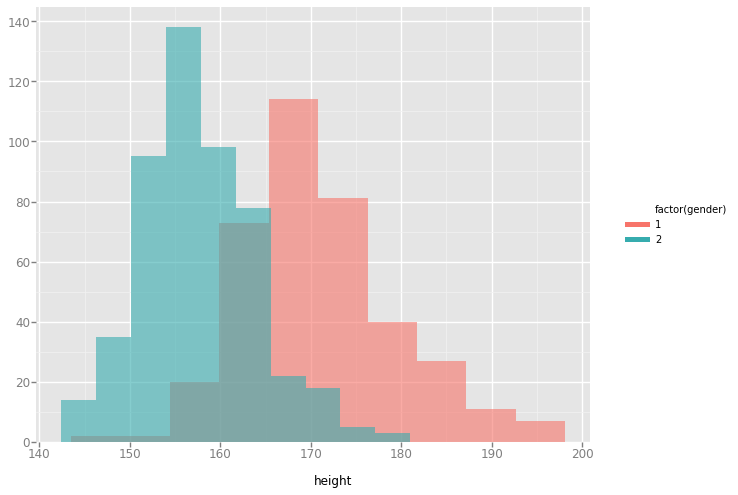

<ggplot: (-9223363300284316977)>

In [272]:
samp_size=len(all_meta)
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)

import random
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=all_meta.loc[val_idx]) +\
    geom_histogram(alpha=0.6)

## Random Forest

In [282]:
y = np.array(y)

In [283]:
from sklearn.ensemble import RandomForestRegressor
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, y)

m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [3]:
preds = m.predict(val)

NameError: name 'm' is not defined

In [285]:
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_

(0.8439407662079724, 0.11804699118137751, 0.0804589756030738)

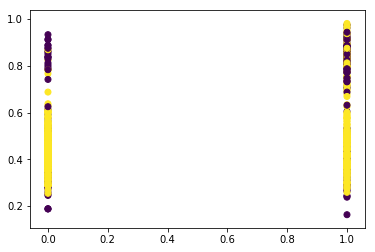

In [286]:
plt.scatter(y_val,preds,c=list(val[:,7726]), marker='o')

In [2]:
heights = m.predict(df_test).tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

NameError: name 'm' is not defined

## NN1

In [1]:
cat_vars = ['gender','nationality']
contin_vars = X.columns[:-2]

NameError: name 'X' is not defined

In [194]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test,is_reg=False)

In [195]:
cat_sz = [(c, 3) for c in cat_vars]
cat_sz

[('gender', 3), ('nationality', 3)]

In [196]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(3, 2), (3, 2)]

In [197]:
y_range = (130,210)

In [198]:
#m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
#                   0, 1, [256,128,64], [0.3,0.5,0.3], y_range=y_range)

In [213]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])

In [214]:
lr = 1e-3

In [227]:
m.lr_find()

 43%|████▎     | 9/21 [00:00<00:00, 87.59it/s, loss=46.3]


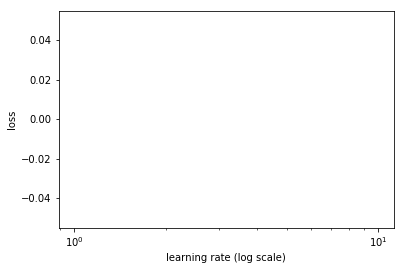

In [228]:
m.sched.plot()

In [229]:
m.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      55.250753  62.687112 
    1      58.415913  64.20576                             
    2      56.39197   62.964787                          



[array([62.96479])]

In [230]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      56.733091  62.744966 
    1      49.164127  62.002885                            
    2      44.179577  61.256397                          
    3      42.012801  60.872404                            
    4      39.967664  60.322566                          
    5      43.533669  60.629964                            
    6      42.154946  58.021469                          
    7      41.29138   57.008608                          
    8      40.034128  56.676835                          
    9      40.916238  60.169139                            



[array([60.16914])]

In [983]:
m.save('nn_model1') #R2=0.355

 24%|██▍       | 12/50 [00:00<00:00, 119.82it/s, loss=43.2]

epoch      trn_loss   val_loss                             
    0      80.888028  151.194055



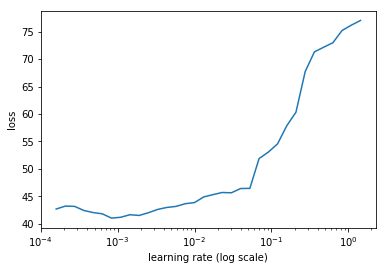

In [984]:
m.lr_find()
m.sched.plot()

In [985]:
m.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      50.995664  42.544632 
    1      43.480691  41.338056                            
    2      42.126355  41.464497                            



[array([41.4645])]

In [1026]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      57.78584   49.578513 
    1      53.775634  46.085355                            
    2      51.614049  43.825487                            
    3      50.302809  40.732563                            
    4      49.565065  43.737697                           
    5      47.954103  40.983987                            
    6      47.264173  38.763312                          
    7      46.305101  38.572067                            
    8      45.49319   38.968085                            
    9      46.022123  39.092998                            



[array([39.093])]

In [987]:
m.save('nn_model2') #R2=0.436

In [9]:
m.load('nn_model2')

NameError: name 'm' is not defined

In [231]:
# Predict the heights for the test set
heights = m.predict(True)
heights=heights.reshape(137)
heights = heights.tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : adf40834-afd7-4b4d-bb1d-a0116c14b777


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : adf40834-afd7-4b4d-bb1d-a0116c14b777


100% |██████████|[00:00<00:00]  109.49% /s] 


CrowdAI.Event.Job.INFO : (adf40834-afd7-4b4d-bb1d-a0116c14b777) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.073840333075 ; MSE : 94.1487447856
CrowdAI.Event.Job.COMPLETE : adf40834-afd7-4b4d-bb1d-a0116c14b777	   🍺 


## NN2

In [972]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (140,200)

In [317]:
maf=pd.read_csv('../predict_height/lib/maf.csv',index_col=0)

In [321]:
sum([x in maf.index for x in all_bim.snp])

628

In [792]:
# Instantiate a linear model
x_train=X
y_train=y
x_test=df_test
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)

In [793]:
#Convert heights from np.array to a list (to ensure it is JSON serializable)
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")

heights = heights.tolist()
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.69% /s] 
          
  0% |          |[16:49<?]  ?% /s] .69% /s] 


CrowdAI.Event.Job.INFO : (bc1ef311-9598-4a6c-a9a2-cce75662d779) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0365818509984 ; MSE : 105.373709981
CrowdAI.Event.Job.COMPLETE : bc1ef311-9598-4a6c-a9a2-cce75662d779	   🍺 


In [ ]:
import preprocess
import argparse
import models


def init_args():
    parser = argparse.ArgumentParser(description='Train and save models')
    parser.add_argument('train_datesets', help='Input csv file for training output from parse_inputs.py')
    parser.add_argument('-m', '--model', help='Train model, comma to separate', default='gbr')
    parser.add_argument('-d', '--model-dir', help='Model directory', default='models')
    parser.add_argument('-l', '--list-models', help='List available models', action='store_true')
    args = parser.parse_args()
    return args


def main():
    args = init_args()
    if args.list_models:
        print('\n'.join(models.get_model_names()))
        exit()
    m = args.model.split(',')
    dict_m = models.get_models(m)
    x, y = preprocess.load_data(args.train_datesets)
    for model_name in dict_m:
        model = dict_m[model_name]
        print('Training model %s' % model_name)
        model.fit(x, y)
        models.save_model(model, model_name, args.model_dir)
        print('Train finished, save to %s' % args.model_dir)

